# PRÀCTICA 1 - REGRESSIÓ

1597487 | Manuel Arnau Fernández

1600123 | Alba Fernández Coronado

1605547 | Marina Palomar González

## 1. Descripció de les dades

In [67]:
# Carregant les llibreries necessàries
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import collections as col
import scipy.stats as stats
import random as rand
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
import scipy.stats
from sklearn.metrics import mean_squared_error , r2_score

# Per importar data
#from google.colab import files
#import io

In [68]:
# Obrir dataset
dataset = pd.read_csv('./insurance.csv')
print(f'Mida de les dades: {dataset.shape}')
dataset.head()

Mida de les dades: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [69]:
# Entenent els tipus de variables de cada atribut
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [70]:
dataset_cp = pd.concat([dataset, pd.get_dummies(dataset.region, prefix='region')], axis=1)
dataset_cp = pd.concat([dataset_cp, pd.get_dummies(dataset.smoker, drop_first=True, prefix='smoker')], axis=1)
dataset_cp = pd.concat([dataset_cp, pd.get_dummies(dataset.sex, drop_first=True, prefix='is')], axis=1)
dataset_cp = dataset_cp.drop(['smoker'], axis=1)
dataset_cp = dataset_cp.drop(['sex'], axis=1)
dataset_cp = dataset_cp.drop(['region'], axis=1)
dataset_cp.head()

,age,bmi,children,charges,region_northeast,region_northwest,region_southeast,region_southwest,smoker_yes,is_male
0,19,27.900,0,16884.92400,0,0,0,1,1,0
1,18,33.770,1,1725.55230,0,0,1,0,0,1
2,28,33.000,3,4449.46200,0,0,1,0,0,1
3,33,22.705,0,21984.47061,0,1,0,0,0,1
4,32,28.880,0,3866.85520,0,1,0,0,0,1


In [71]:
# Separem X i Y
Y = dataset_cp['charges']
X = dataset_cp.drop(['charges'], axis=1)

### ANÀLISI DELS ATRIBUTS

Southwest: 325, Southeast: 364, Northeast: 324, Northwest: 325


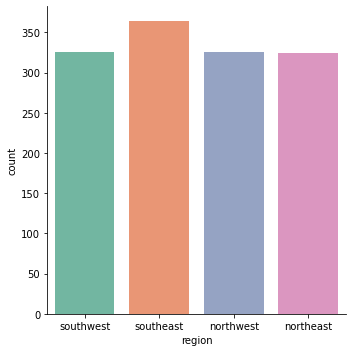

In [72]:
# Estudi de region
sns.catplot(x = "region", data = dataset, kind = "count", palette='Set2')
count = col.Counter(dataset['region'])
sw = count['southwest']
se = count['southeast']
ne = count['northeast']
nw = count['northwest']
print(f'Southwest: {sw}, Southeast: {se}, Northeast: {ne}, Northwest: {nw}')

Zero fills: 574, Un fill: 324, Dos fills: 240, Tres fills: 157, Quatre fills: 25, Cinc fills: 18


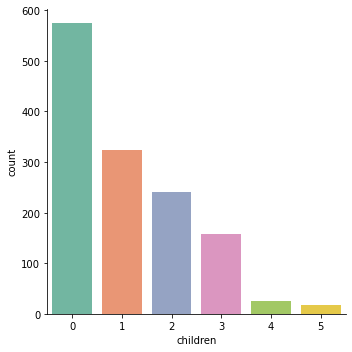

In [73]:
# Estudi de children
sns.catplot(x = "children", data = dataset, kind = "count", palette='Set2')
count = col.Counter(dataset['children'])
z = count[0]
u = count[1]
d = count[2]
t = count[3]
q = count[4]
c = count[5]
print(f'Zero fills: {z}, Un fill: {u}, Dos fills: {d}, Tres fills: {t}, Quatre fills: {q}, Cinc fills: {c}')

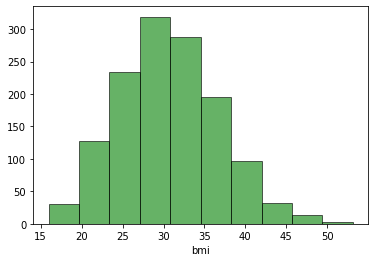

<AxesSubplot:xlabel='bmi', ylabel='Density'>

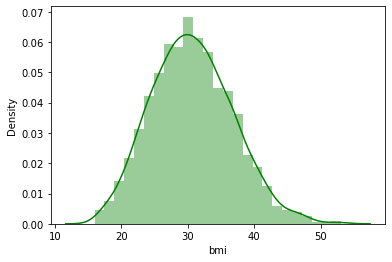

In [74]:
# Estudi de BMI
plt.hist(dataset['bmi'], color= 'green', edgecolor = 'black', alpha = 0.6)
plt.xlabel('bmi')
plt.show()

sns.distplot(dataset['bmi'], color= 'green')

Nombre total outliers en la distribució BMI: 9.


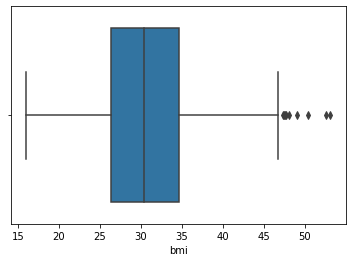

In [75]:
sns.boxplot(dataset['bmi'])
Q1 = dataset['bmi'].quantile(0.25)
Q3 = dataset['bmi'].quantile(0.75)
IQR = Q3 - Q1
total_outlier_num = ((dataset['bmi'] < (Q1 - 1.5 * IQR)) | (dataset['bmi'] > (Q3 + 1.5 * IQR))).sum()
print(f'Nombre total outliers en la distribució BMI: {total_outlier_num}.')

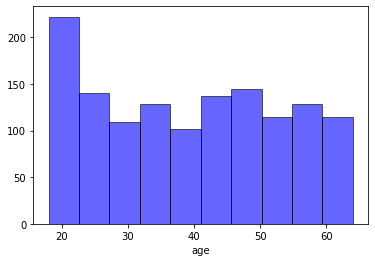

<AxesSubplot:xlabel='age', ylabel='Density'>

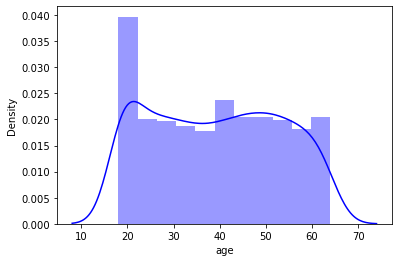

In [76]:
# Estudi de age
plt.hist(dataset['age'], color= 'blue', edgecolor = 'black', alpha = 0.6)
plt.xlabel('age')
plt.show()

sns.distplot(dataset['age'], color= 'blue')

Homes: 676, Dones: 662


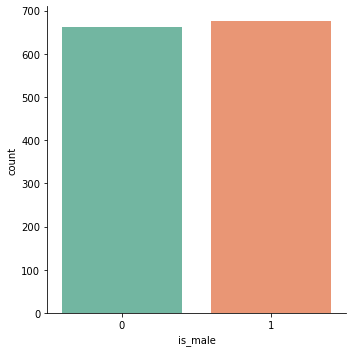

In [77]:
# Estudi de sex
sns.catplot(x = "is_male", data = X, kind = "count", palette='Set2')
count = col.Counter(X['is_male'])
female = count[0]
male = count[1]
print(f'Homes: {male}, Dones: {female}')

No fumadors: 1064, Fumadors: 274


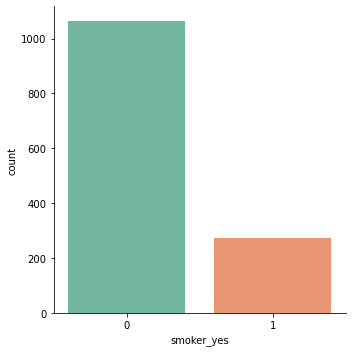

In [78]:
# Estudi de smoke
sns.catplot(x = "smoker_yes", data = X, kind = "count", palette='Set2')
count = col.Counter(X['smoker_yes'])
no_s = count[0]
s = count[1]
print(f'No fumadors: {no_s}, Fumadors: {s}')

### INFORMACIÓ DE LA VARIABLE RESPOSTA

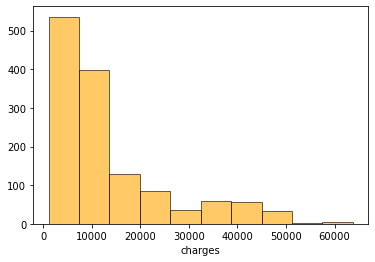

<AxesSubplot:xlabel='charges', ylabel='Density'>

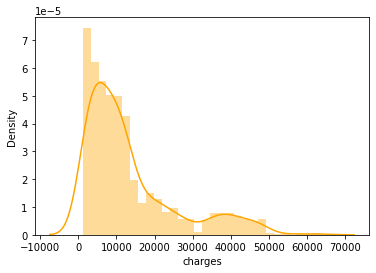

In [79]:
#DISTRIBUCIÓ DE LA VARIABLE OBJECTIU: EXPONENCIAL
plt.hist(Y, color= 'orange', edgecolor = 'black', alpha = 0.6)
plt.xlabel('charges')
plt.show()
sns.distplot(Y, color= 'orange')

Nombre total outliers en la distribució CHARGES: 139.


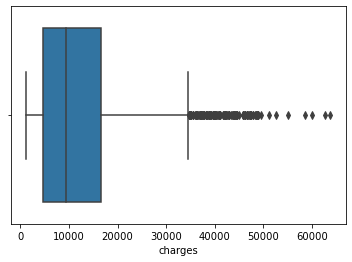

In [80]:
sns.boxplot(Y)
Q1 = Y.quantile(0.25)
Q3 = Y.quantile(0.75)
IQR = Q3 - Q1
total_outlier_num = ((Y < (Q1 - 1.5 * IQR)) | (Y > (Q3 + 1.5 * IQR))).sum()
print(f'Nombre total outliers en la distribució CHARGES: {total_outlier_num}.')

### ANÀLISI DELS ATRIBUTS RESPECTE LA VARIABLE RESPOSTA

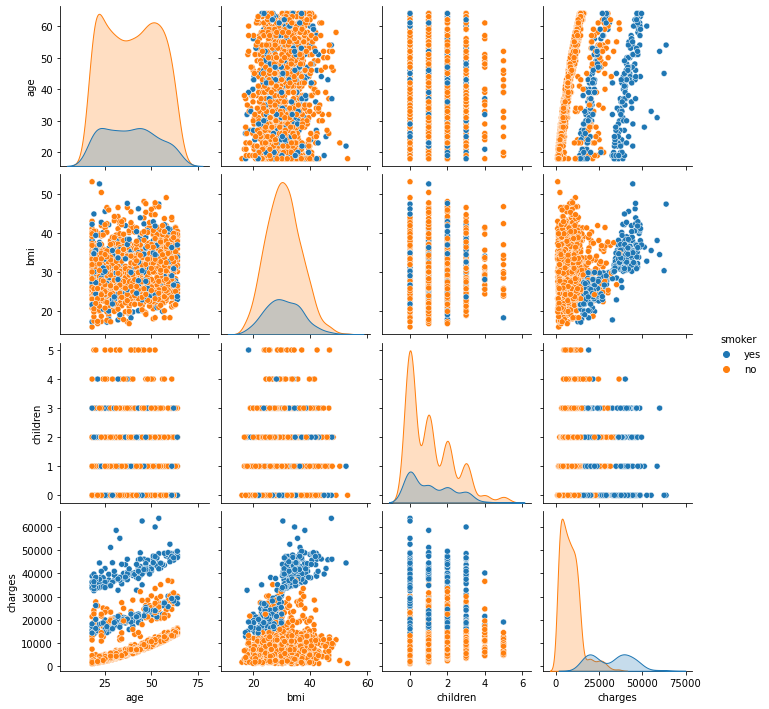

In [81]:
# Tracem relacions per parelles d'atributs no binaris
sns.pairplot(dataset, hue = 'smoker')

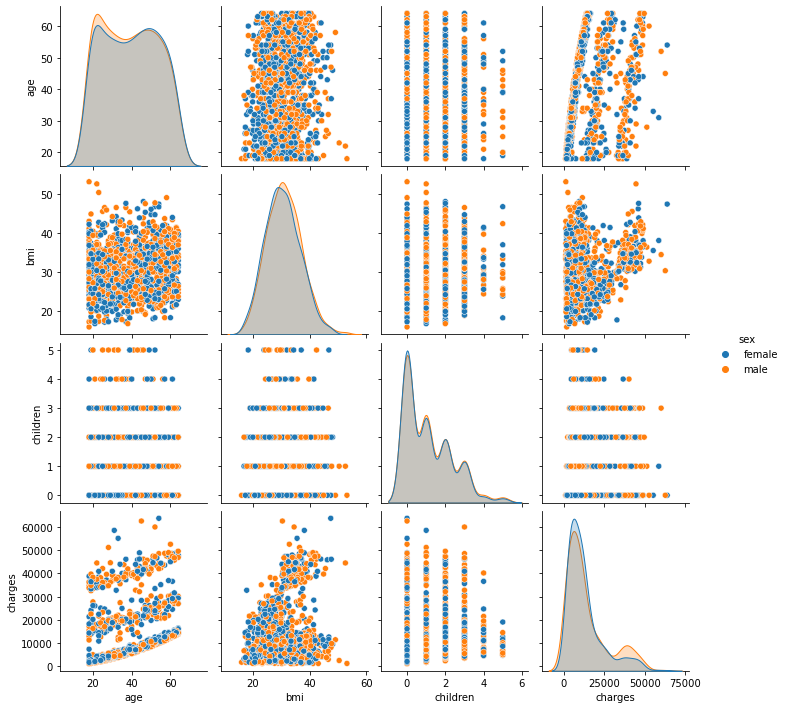

In [82]:
sns.pairplot(dataset, hue = 'sex')

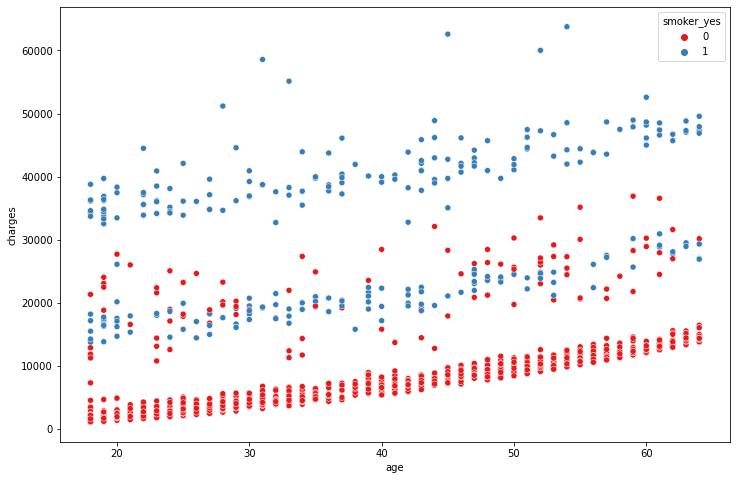

In [83]:
# Comparació edad i preus segons fumadors
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.scatterplot(x = 'age', y = 'charges', hue='smoker_yes', data=dataset_cp, palette='Set1')

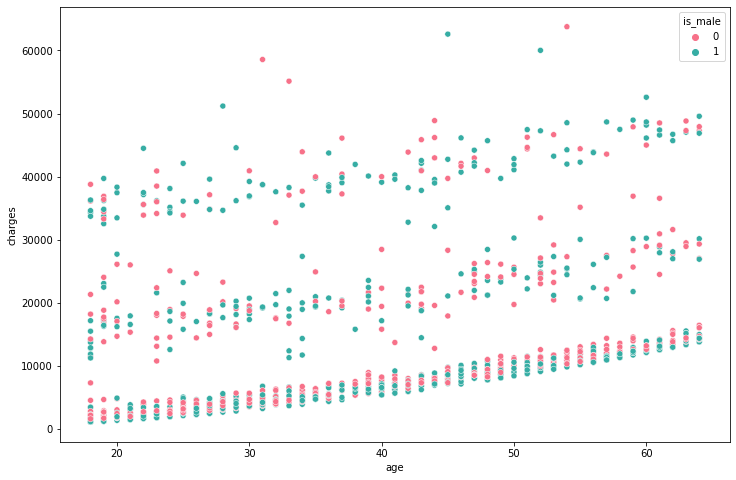

In [84]:
# Comparació edad i preu segons sexe
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.scatterplot(x = 'age', y = 'charges', hue='is_male', data=dataset_cp, palette='husl')

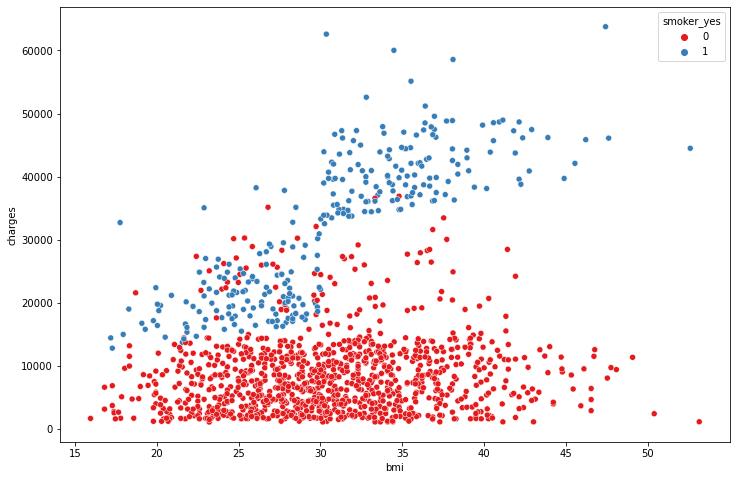

In [85]:
# Comparació edad i preus segons fumadors
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.scatterplot(x = 'bmi', y = 'charges', hue='smoker_yes', data=dataset_cp, palette='Set1')

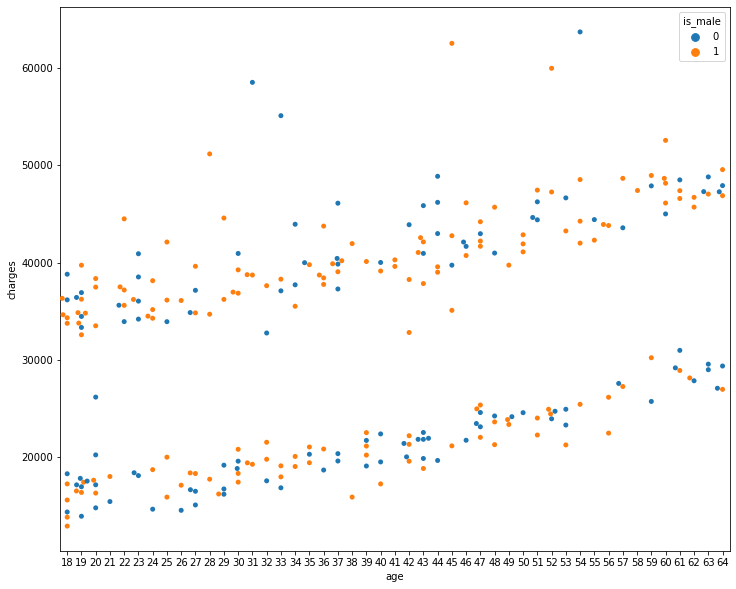

In [86]:
# Còpia de les dades de dones a un altre data
fumadors = dataset_cp[dataset_cp['smoker_yes'] == 1].copy()

# Comparació del 'charges' respecte al nombre de fills
plt.figure(figsize=(12,10))
sns.swarmplot(y='charges',x='age', hue='is_male',data=fumadors)
plt.show()

In [87]:
H0 = "els homes fumadors paguen més que les dones fumadores"
H1 = "els homes fumadors no paguen més que les dones fumadores"

h = fumadors[fumadors.is_male == 1]['charges']
d = fumadors[fumadors.is_male == 0]['charges']

# Aplicació test Anova per comparar múltiples mitjanes
f_stat, p_valor = stats.f_oneway(h,d)

if(p_valor<0.05):
    print(f'{p_valor} -> Es rebutja la hipòtesi nul·la, per tant {H1}')
else:
    print(f'{p_valor} -> No es rebutja la hipòtesi nul·la, per tant {H0}') 

0.0944795303099132 -> No es rebutja la hipòtesi nul·la, per tant els homes fumadors paguen més que les dones fumadores


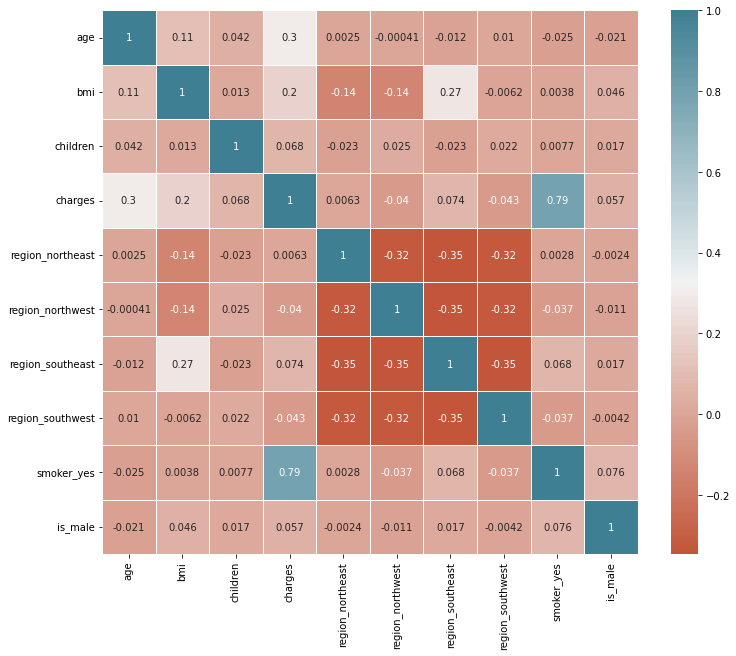

In [88]:
correlacio = dataset_cp.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200))

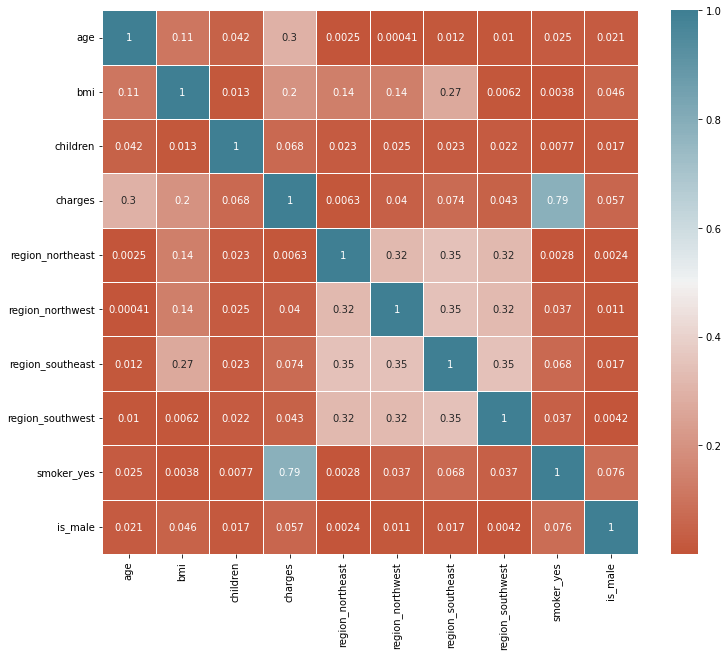

In [89]:
#Fem el heatmap en valor absolut per veure més clarament les correlacions entre les variables
#El que ens interessa és saber si les variables estan correlacionades o no, s¡no si ho estan positiva o negativament.
correlacio = dataset_cp.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(abs(correlacio), annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200))

## Extra. Visualització Principal Component Analysis

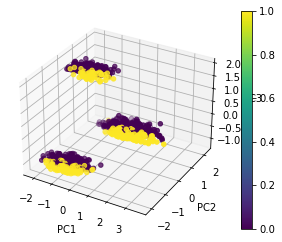

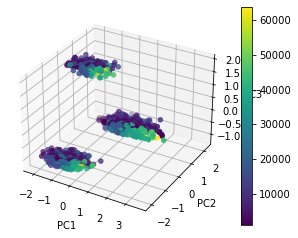

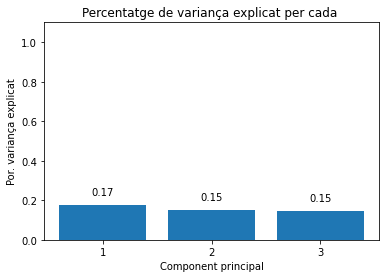

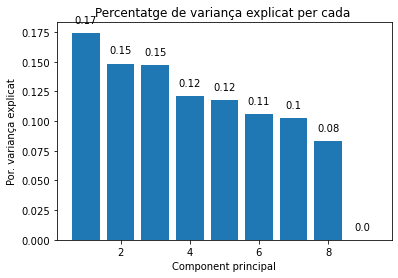

In [137]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

model = PCA(n_components=3)
model.fit(X_scaled)
data_pca = pd.DataFrame(
    data = model.components_,
    columns = X.columns,
    index = ['PC1','PC2','PC3'])

X_pca = model.transform(X_scaled)
#MIREM COM QUEDA EL PCA PER SI ES FUMADOR O NO
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=X['smoker_yes'])
fig.colorbar(p)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

#MIREM COM QUEDA EL PCA SEGONS ELS CHARGES

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=Y)
fig.colorbar(p)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

#PERCENTATGE DE VARIANÇA DE CADA COMPONENT

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model.n_components_) + 1,
    height = model.explained_variance_ratio_
)

for x, y in zip(np.arange(len(data_pca.columns)) + 1, model.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(model.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Percentatge de variança explicat per cada ')
ax.set_xlabel('Component principal')
ax.set_ylabel('Por. variança explicat');
#SUPER INUTIL, NO EXPLICA RES. AIXÒ ES DEU A QUE LES DADES ESTAN MOLT POC CORRELACIONADES ENTRE ELLES JA DE PER SI

#UN MODEL AMB TOTS ELS PCA POSSIBLES, PER VEURE QUANTES DIMENSIONS REALMENT PODRÍEM REDUÏR

model_complet = PCA()
model_complet.fit(X_scaled)

data_pca_complet = pd.DataFrame(
    data = model_complet.components_,
    columns = X.columns,
    index = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model_complet.n_components_) + 1,
    height = model_complet.explained_variance_ratio_
)

for x, y in zip(np.arange(len(data_pca_complet.columns)) + 1, model_complet.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
ax.set_title('Percentatge de variança explicat per cada ')
ax.set_xlabel('Component principal')
ax.set_ylabel('Por. variança explicat');
plt.show()


## 2. Primeres regresions

In [ ]:
# Funció per normalitzar les dades X
def standarize(xtrain):
    mean = xtrain.mean(0)
    std = xtrain.std(0)
    x_t = xtrain - mean[None, :]
    x_t /= std[None, :]
    return x_t

Com la variable amb més importancia és *smoker_yes*, es faràn dos models de regressió depenent de si l'usuari es fumador o no, per tant, separem les dades:

In [ ]:
fumadors = dataset_cp[dataset_cp['smoker_yes'] == 1].copy()
nofumadors = dataset_cp[dataset_cp['smoker_yes'] == 0].copy()
fumadors = fumadors.drop(['smoker_yes'], axis=1)
nofumadors = nofumadors.drop(['smoker_yes'], axis=1)

fy = fumadors['charges']
nfy = nofumadors['charges']

fumadors = fumadors.drop(['charges'], axis=1)
nofumadors = nofumadors.drop(['charges'], axis=1)

fnorm = standarize(fumadors)
nfnorm = standarize(nofumadors)

In [ ]:
# Separem les dades de train i test
XF_train, XF_test, YF_train, YF_test = train_test_split(fnorm, fy, test_size=0.3, random_state=99)
XNF_train, XNF_test, YNF_train, YNF_test = train_test_split(nfnorm, nfy, test_size=0.3, random_state=99)

### REGRESSIONS SIMPLE

In [ ]:
def RegressioSimple(atribut, Xtrain, Ytrain):
    lm = LinearRegression()
    np_data=Xtrain[atribut].to_numpy()
    x = np_data.reshape(-1,1)
    lm.fit(x,Ytrain)

    m = np.linspace(Xtrain[atribut].min(), Xtrain[atribut].max(), 100)
    r = [lm.coef_ * i + lm.intercept_ for i in m]

    #plt.figure()
    #ax = plt.scatter(Xtrain[atribut],Ytrain, hue = 'is_male')
    #plt.plot(m, r, 'r')
    plt.figure(figsize=(8,5))
    ax = sns.scatterplot(y=Ytrain,x=Xtrain[atribut], hue='is_male',data=Xtrain)
    plt.plot(m, r, 'r')
    plt.show()
    
    pred = [lm.coef_ * i + lm.intercept_ for i in Xtrain[atribut]]
    pred = np.asarray(pred)
    Ytrain2 = np.asarray(Ytrain)

    MSE = mean_squared_error(Ytrain2, pred)
    r2 = r2_score(Ytrain2, pred)

    print("Mean squeared error: ", MSE)
    print("R2 score: ", r2)

In [ ]:
RegressioSimple('age', XF_train, YF_train)
RegressioSimple('age', XNF_train, YNF_train)

In [ ]:
RegressioSimple('bmi', XF_train, YF_train)
RegressioSimple('bmi', XNF_train, YNF_train)

Te un mse de la ostia i fem una trasformacio log per obtenir millor resultats

In [ ]:
fylog = np.log(fy)
nfylog = np.log(nfy)

In [ ]:
# Tornem a separem les dades de train i test amb la nova Y
XF_train, XF_test, YF_train, YF_test = train_test_split(fnorm, fylog, test_size=0.3, random_state=99)
XNF_train, XNF_test, YNF_train, YNF_test = train_test_split(nfnorm, nfylog, test_size=0.3, random_state=99)

In [ ]:
RegressioSimple('age', XF_train, YF_train)
RegressioSimple('age', XNF_train, YNF_train)

In [ ]:
RegressioSimple('bmi', XF_train, YF_train)
RegressioSimple('bmi', XNF_train, YNF_train)

### REGRESSIONS MÚLTIPLES

In [ ]:
lmF = LinearRegression()
modelFumadors = lmF.fit(XF_train,YF_train)
predFumadors = lmF.predict(XF_test) # a una web fica test

In [ ]:
pd.DataFrame(modelFumadors.coef_, fumadors.columns, columns=["Coeff"])

In [ ]:
print('intercept:',modelFumadors.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(YF_test, predFumadors))
print('Coefficient of determination (R^2): %.2f'% r2_score(YF_test, predFumadors))

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=predFumadors,x=YF_test, hue='is_male',data=XF_test)
plt.plot(YF_test, YF_test, 'r')
plt.show()

In [ ]:
ErrorF = list(predFumadors - YF_test)

plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=ErrorF,x=YF_test, hue='is_male',data=XF_test)
plt.show()

In [ ]:
lmNF = LinearRegression()
modelNoFumadors = lmNF.fit(XNF_train,YNF_train)
predNoFumadors = lmNF.predict(XNF_test)

In [ ]:
pd.DataFrame(modelNoFumadors.coef_, nofumadors.columns, columns=["Coeff"])

In [ ]:
print('intercept:',modelNoFumadors.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(YNF_test, predNoFumadors))
print('Coefficient of determination (R^2): %.2f'% r2_score(YNF_test, predNoFumadors))

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=predNoFumadors,x=YNF_test, hue='is_male',data=XNF_test)
plt.plot(YNF_test, YNF_test, 'r')
plt.show()

In [ ]:
ErrorNF = list(predNoFumadors - YNF_test)

plt.figure(figsize=(8,5))
ax = sns.scatterplot(y=ErrorNF,x=YNF_test, hue='is_male',data=XNF_test)
plt.show()

## 3. Descens del gradient

In [ ]:
class Regressor(object):
    def __init__(self, w0, w1, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.alpha = alpha

        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        pass
    
    def __update(self, hy, y):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        pass
    
    def train(self, max_iter, epsilon):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        pass

In [ ]:
%matplotlib notebook

# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple
x_val = np.random.random((100, 2))
y_val = np.random.random((100, 1))
regr = regression(x_val, y_val)
predX3D = regr.predict(x_val)

# Afegim els 1's
A = np.hstack((x_val,np.ones([x_val.shape[0],1])))
w = np.linalg.lstsq(A,predX3D)[0]

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 =  malla * (max(x_val[:,0]) - min(x_val[:,0]))/2 + min(x_val[:,0])
malla_x2 =  malla * (max(x_val[:,1]) - min(x_val[:,1]))/2 + min(x_val[:,1])

#la funcio meshgrid ens aparella un de malla_x1 amb un de malla_x2, per atot
#element de mallax_1 i per a tot element de malla_x2.
xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)

# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean

#ara creem la superficies que es un pla
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot,yplot,zplot, color='red')
plt3d.scatter(x_val[:,0],x_val[:,1],y_val)

In [ ]:
len(predictions)